In [15]:
import psi4
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, Draw

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import os
import sys
import time
import platform
import psutil

my_system = platform.uname()

import subprocess

import psutil
import threading

# --- System RAM Information ---
ram = psutil.virtual_memory()
print(f"Total RAM: {round(ram.total / (1024**3), 2)} GB")
print(f"Available RAM: {round(ram.available / (1024**3), 2)} GB")
print(f"Used RAM: {round(ram.used / (1024**3), 2)} GB")
print(f"RAM Usage Percentage: {ram.percent}%")
print("-" * 30)

# --- Active Threads Information ---
thread_count = threading.active_count()
print(f"Number of active threads: {thread_count}")



print("Psi4:", psi4.__version__)
print("RDKit:", rdkit.__version__)

# system properties



Total RAM: 23.38 GB
Available RAM: 14.3 GB
Used RAM: 9.08 GB
RAM Usage Percentage: 38.8%
------------------------------
Number of active threads: 9
Psi4: 1.10
RDKit: 2025.09.4


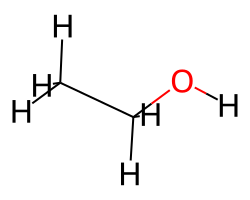

In [16]:
smiles = "CCO"  # etanol como placeholder
mol = Chem.MolFromSmiles(smiles)
mol = Chem.AddHs(mol)

AllChem.EmbedMolecule(mol, AllChem.ETKDG())
AllChem.UFFOptimizeMolecule(mol)

molecule = Draw.MolToImage(mol, size=(250, 200) )

display(molecule)



In [17]:
conf = mol.GetConformer()

xyz = []
for atom in mol.GetAtoms():
    pos = conf.GetAtomPosition(atom.GetIdx())
    xyz.append(f"{atom.GetSymbol()} {pos.x:.6f} {pos.y:.6f} {pos.z:.6f}")

xyz_str = f"{mol.GetNumAtoms()}\n\n" + "\n".join(xyz)
print(xyz_str)


9

C -0.977337 0.318437 0.153960
C 0.393958 -0.325870 0.285601
O 1.311891 0.353248 -0.524413
H -1.320898 0.269232 -0.901137
H -0.930434 1.381138 0.473571
H -1.707067 -0.218824 0.795782
H 0.328519 -1.391585 -0.027782
H 0.719464 -0.278308 1.348626
H 2.181904 -0.107467 -0.398877


In [18]:
psi4.set_memory("2 GB")
psi4.set_num_threads(8)
psi4.core.set_output_file("psi4_output.dat", False)

molecule = psi4.geometry(xyz_str)



  Memory set to   1.863 GiB by Python driver.
  Threads set to 4 by Python driver.


In [47]:
methods = [
    # muy rápido
    ("hf",        {"basis": "sto-3g"}),

    # rápido y base decente
    ("hf",        {"basis": "def2-SVP"}),

    # DFT barato
    ("b3lyp",     {"basis": "def2-SVP"}),

    # DFT más moderno (un poco más caro)
    ("wb97x-d",   {"basis": "def2-SVP"}),

    # referencia wavefunction barata
    ("mp2",       {"basis": "def2-SVP", "scf_type": "df"}),
]

def run_method(method, options):
    psi4.set_options(options)
    e, wfn = psi4.energy(method, return_wfn=True)
    return {
        "method": method,
        "options": options,
        "energy": e,
        "qc_keys": sorted(wfn.variables().keys()),
        "wfn": wfn,   # lo guardamos vivo por ahora
    }



In [48]:
results = []

for m, opts in methods:
    print(f"Running {m} with {opts}")
    res = run_method(m, opts)
    results.append(res)


Running hf with {'basis': 'sto-3g'}
Running hf with {'basis': 'def2-SVP'}
Running b3lyp with {'basis': 'def2-SVP'}
Running wb97x-d with {'basis': 'def2-SVP'}
Running mp2 with {'basis': 'def2-SVP', 'scf_type': 'df'}


In [49]:
for r in results:
    print("\n", r["method"], r["options"])
    for k in r["qc_keys"]:
        print(" ", k)



 hf {'basis': 'sto-3g'}
  CURRENT DIPOLE
  CURRENT ENERGY
  CURRENT REFERENCE ENERGY
  DD SOLVATION ENERGY
  HF KINETIC ENERGY
  HF POTENTIAL ENERGY
  HF TOTAL ENERGY
  HF VIRIAL RATIO
  NUCLEAR REPULSION ENERGY
  ONE-ELECTRON ENERGY
  PCM POLARIZATION ENERGY
  PE ENERGY
  SCF DIPOLE
  SCF ITERATION ENERGY
  SCF ITERATIONS
  SCF TOTAL ENERGIES
  SCF TOTAL ENERGY
  TWO-ELECTRON ENERGY

 hf {'basis': 'def2-SVP'}
  CURRENT DIPOLE
  CURRENT ENERGY
  CURRENT REFERENCE ENERGY
  DD SOLVATION ENERGY
  HF KINETIC ENERGY
  HF POTENTIAL ENERGY
  HF TOTAL ENERGY
  HF VIRIAL RATIO
  NUCLEAR REPULSION ENERGY
  ONE-ELECTRON ENERGY
  PCM POLARIZATION ENERGY
  PE ENERGY
  SCF DIPOLE
  SCF ITERATION ENERGY
  SCF ITERATIONS
  SCF TOTAL ENERGIES
  SCF TOTAL ENERGY
  TWO-ELECTRON ENERGY

 b3lyp {'basis': 'def2-SVP'}
  CURRENT DIPOLE
  CURRENT ENERGY
  CURRENT REFERENCE ENERGY
  DD SOLVATION ENERGY
  DFT FUNCTIONAL TOTAL ENERGY
  DFT TOTAL ENERGY
  DFT VV10 ENERGY
  DFT XC ENERGY
  GRID ELECTRONS ALPHA
  G

In [50]:
from functools import reduce

common_keys = reduce(
    set.intersection,
    [set(r["qc_keys"]) for r in results]
)

sorted(common_keys)


['CURRENT DIPOLE',
 'CURRENT ENERGY',
 'CURRENT REFERENCE ENERGY',
 'DD SOLVATION ENERGY',
 'NUCLEAR REPULSION ENERGY',
 'ONE-ELECTRON ENERGY',
 'PCM POLARIZATION ENERGY',
 'PE ENERGY',
 'SCF DIPOLE',
 'SCF ITERATION ENERGY',
 'SCF ITERATIONS',
 'SCF TOTAL ENERGIES',
 'SCF TOTAL ENERGY',
 'TWO-ELECTRON ENERGY']

In [52]:
import pandas as pd
import numpy as np

def as_float(x):
    try:
        return float(x)
    except Exception:
        return np.nan

rows = []

for r in results:
    wfn = r["wfn"]
    row = {
        "method": r["method"],
        "basis": r["options"].get("basis", None),
        "energy_returned": r["energy"],
    }
    for k in common_keys:
        v = wfn.variable(k)
        row[k] = as_float(v)
    rows.append(row)

df = pd.DataFrame(rows).set_index(["method", "basis"])
print(df)


                  energy_returned  DD SOLVATION ENERGY  ONE-ELECTRON ENERGY  \
method  basis                                                                 
hf      sto-3g        -152.127110                  0.0          -371.328024   
        def2-SVP      -153.967596                  0.0          -372.602948   
b3lyp   def2-SVP      -154.922294                  0.0          -372.927672   
wb97x-d def2-SVP      -154.875552                  0.0          -372.953928   
mp2     def2-SVP      -154.453990                  0.0          -372.603004   

                  PCM POLARIZATION ENERGY  SCF ITERATIONS  \
method  basis                                               
hf      sto-3g                        0.0             8.0   
        def2-SVP                      0.0             9.0   
b3lyp   def2-SVP                      0.0            10.0   
wb97x-d def2-SVP                      0.0             9.0   
mp2     def2-SVP                      0.0            12.0   

                  

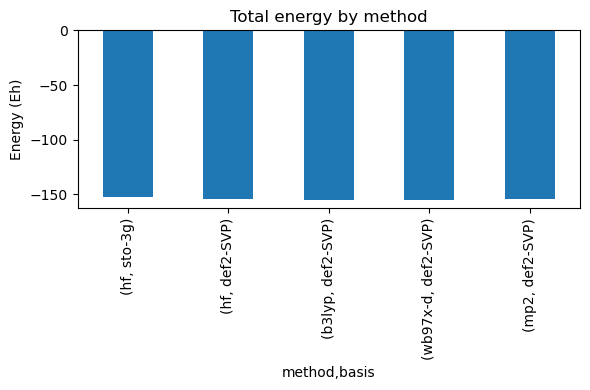

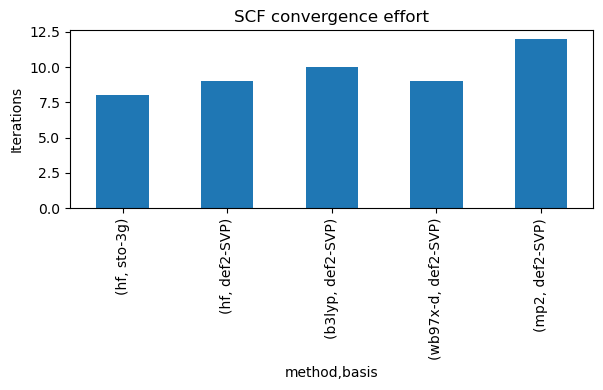

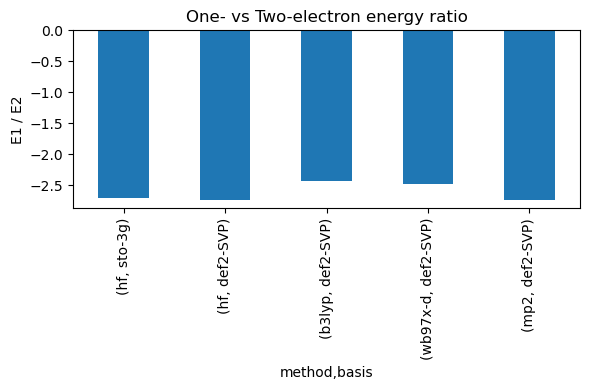

In [59]:
df["CURRENT ENERGY"].plot(kind="bar", figsize=(6,4))
plt.ylabel("Energy (Eh)")
plt.title("Total energy by method")
plt.tight_layout()
plt.show()

df["SCF ITERATIONS"].plot(kind="bar", figsize=(6,4))
plt.ylabel("Iterations")
plt.title("SCF convergence effort")
plt.tight_layout()
plt.show()


(df["ONE-ELECTRON ENERGY"] / df["TWO-ELECTRON ENERGY"]).plot(
    kind="bar", figsize=(6,4)
)
plt.ylabel("E1 / E2")
plt.title("One- vs Two-electron energy ratio")
plt.tight_layout()
plt.show()





In [60]:
common_opts = {
    "basis": "def2-SVP",
    "scf_type": "df",
    "e_convergence": 1e-8,
    "d_convergence": 1e-8,
    "g_convergence": "qchem",  # buen compromiso
}
psi4.set_options(common_opts)


opt_energy, opt_wfn = psi4.optimize("b3lyp", molecule=molecule, return_wfn=True)
opt_energy

mol_opt = opt_wfn.molecule()
mol_opt.update_geometry()

xyz_opt = mol_opt.save_string_xyz()
print(xyz_opt)


	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 4.48e-05

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 8.67e-06

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 2.42e-07

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 2.06e-07

	Previous geometry is closer to target in internal coordinates, so using that one.

	Best geometry has RMS(Delta(q)) = 1.10e-07



Optimizer: Optimization complete!
0 1
 C   -1.257804062849    0.204571393983    0.191793674558
 C    0.104502523908   -0.449333179565    0.333751242314
 O    1.020904602104    0.246090680210   -0.489014827559
 H   -1.593945263315    0.168191609908   -0.856412606304
 H   -1.209826007022    1.262034416835    0.495966120964
 H   -2.006186539046   -0.306579493374    0.817792054639
 H    0.034055338937   -1.519724966926    0.046763901576
 H    0.418061120520   -0.426204827770    1.398743809698
 H    1.887508307515   -0.169017767817   -0.399406388924



In [67]:
QC_KEYS = [
    "CURRENT ENERGY",
    "CURRENT REFERENCE ENERGY",
    "SCF TOTAL ENERGY",
    "NUCLEAR REPULSION ENERGY",
    "ONE-ELECTRON ENERGY",
    "TWO-ELECTRON ENERGY",
    "SCF ITERATIONS",
    "DD SOLVATION ENERGY",
    "PCM POLARIZATION ENERGY",
    "PE ENERGY",
]

def run_sp(method, opts, mol):
    psi4.set_options(opts)
    e, wfn = psi4.energy(method, molecule=mol, return_wfn=True)

    row = {
        "method": method,
        "basis": opts.get("basis"),
        "energy_returned": e,
        "SCF ITERATIONS": float(wfn.variable("SCF ITERATIONS")) if "SCF ITERATIONS" in wfn.variables() else np.nan,
    }

    for k in QC_KEYS:
        if k in wfn.variables():
            try:
                row[k] = float(wfn.variable(k))
            except Exception:
                row[k] = np.array(wfn.variable(k))

    return row, wfn


methods = [
    ("hf",      {"basis": "sto-3g",   "scf_type": "pk"}),     # bien barato
    ("hf",      {"basis": "def2-SVP", "scf_type": "df"}),
    ("b3lyp",   {"basis": "def2-SVP", "scf_type": "df"}),
    ("wb97x-d", {"basis": "def2-SVP", "scf_type": "df"}),
    ("mp2",     {"basis": "def2-SVP", "scf_type": "df"}),
]


rows_opt = []
wfns_opt = {}

for m, opts in methods:
    # mezcla opts con common_opts donde aplique (sin pisar basis/scf_type)
    run_opts = {**common_opts, **opts}
    row, w = run_sp(m, run_opts, mol_opt)
    rows_opt.append(row)
    wfns_opt[(m, opts.get("basis"))] = w

df_opt = pd.DataFrame(rows_opt).set_index(["method", "basis"])
print(df_opt)


                  energy_returned  SCF ITERATIONS  CURRENT ENERGY  \
method  basis                                                       
hf      sto-3g        -152.129609            10.0     -152.129609   
        def2-SVP      -153.966259            12.0     -153.966259   
b3lyp   def2-SVP      -154.923510            12.0     -154.923510   
wb97x-d def2-SVP      -154.876235            12.0     -154.876235   
mp2     def2-SVP      -154.454690            12.0     -154.454690   

                  CURRENT REFERENCE ENERGY  SCF TOTAL ENERGY  \
method  basis                                                  
hf      sto-3g                 -152.129609       -152.129609   
        def2-SVP               -153.966259       -153.966259   
b3lyp   def2-SVP               -154.923510       -154.923510   
wb97x-d def2-SVP               -154.876235       -154.876235   
mp2     def2-SVP               -153.966259       -153.966259   

                  NUCLEAR REPULSION ENERGY  ONE-ELECTRON ENERGY  \


In [64]:
comp_cols = ["CURRENT ENERGY", "SCF TOTAL ENERGY", "NUCLEAR REPULSION ENERGY", "SCF ITERATIONS"]

before = df[comp_cols].copy()
after  = df_opt[comp_cols].copy()

delta = after - before
delta


CURRENT ENERGY  SCF TOTAL ENERGY  NUCLEAR REPULSION ENERGY  \
method  basis                                                                  
hf      sto-3g         -0.002499         -0.002499                 -0.771921   
        def2-SVP        0.001336          0.001336                 -0.771921   
b3lyp   def2-SVP       -0.001216         -0.001216                 -0.771921   
wb97x-d def2-SVP       -0.000683         -0.000683                 -0.771921   
mp2     def2-SVP       -0.000701          0.001336                 -0.771921   

                  SCF ITERATIONS  
method  basis                     
hf      sto-3g               2.0  
        def2-SVP             3.0  
b3lyp   def2-SVP             2.0  
wb97x-d def2-SVP             3.0  
mp2     def2-SVP             0.0

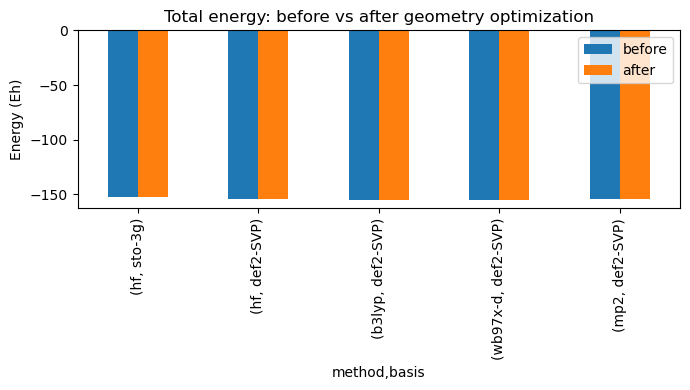

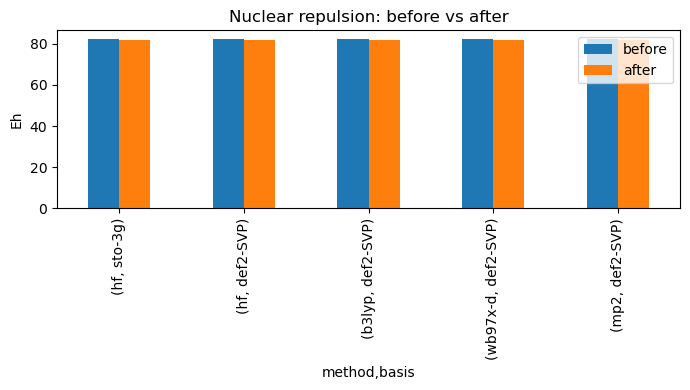

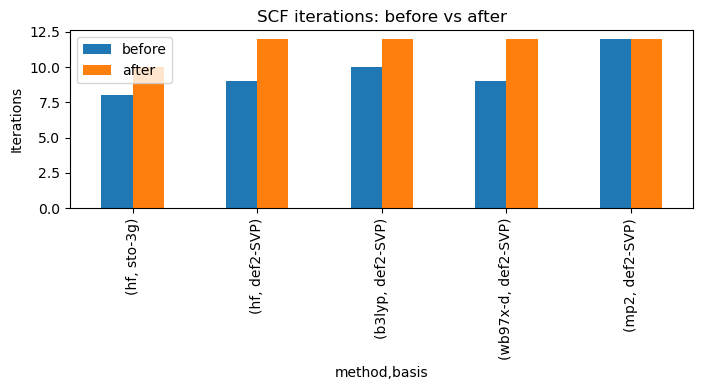

In [66]:
plot_df = pd.DataFrame({
    "before": before["CURRENT ENERGY"],
    "after":  after["CURRENT ENERGY"],
})

ax = plot_df.plot(kind="bar", figsize=(7,4))
ax.set_ylabel("Energy (Eh)")
ax.set_title("Total energy: before vs after geometry optimization")
plt.tight_layout()
plt.show()
plot_nr = pd.DataFrame({
    "before": before["NUCLEAR REPULSION ENERGY"],
    "after":  after["NUCLEAR REPULSION ENERGY"],
})

ax = plot_nr.plot(kind="bar", figsize=(7,4))
ax.set_ylabel("Eh")
ax.set_title("Nuclear repulsion: before vs after")
plt.tight_layout()
plt.show()


plot_it = pd.DataFrame({
    "before": before["SCF ITERATIONS"],
    "after":  after["SCF ITERATIONS"],
})

ax = plot_it.plot(kind="bar", figsize=(7,4))
ax.set_ylabel("Iterations")
ax.set_title("SCF iterations: before vs after")
plt.tight_layout()
plt.show()





In [79]:
psi4.set_options({
    "basis": "def2-SVP",
    "scf_properties": ["dipole", "quadrupole"],
})

psi4.properties("hf")    # devuelve dipolo/cuadrupolo


-153.9662591726324

In [83]:
psi4.set_options({"pop_mulliken": True})
psi4.properties("hf")



Error: option POP_MULLIKEN is not contained in the list of available options.

Did you mean? 



ValidationError: Error setting options: {'pop_mulliken': (True, RuntimeError('\nFatal Error: POP_MULLIKEN is not a valid option.\nError occurred in file: /home/conda/feedstock_root/build_artifacts/psi4_1767989031306/work/psi4/src/psi4/liboptions/liboptions.h on line: 55\nThe most recent 5 function calls were:\n\npsi::PsiException::PsiException(std::__cxx11::basic_string<char, std::char_traits<char>, std::allocator<char> >, char const*, int)\n'))}

In [78]:
print(oe)
